Demonstrate how LTP-IE can be used to store and decode paired and triplet associations.

# Network architecture

In [1]:
%matplotlib inline
from copy import deepcopy as copy
import sys

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd
from scipy import stats

from aux import lognormal_mu_sig, sgmd
from disp import set_font_size, set_n_x_ticks, set_n_y_ticks
from ntwk import LIFNtwk, join_w
from replay import cxn, smln


# model params
M = {
    # PC membrane
    'T_M_PC': 0.05, 'E_L_PC': -0.068, 'V_TH_PC': -0.036, 'V_R_PC': -0.068, 'T_R_PC': 0.008,
    
    # PC architecture
    'N_LYR': 20,  # num layers
    'N_PC_LYR': 1000,  # num PCs per layer
    'N_PC': 20*1000,
    'W_PC_PC': 0.03, 'L_PC_PC': 0.083, 'W_MIN_PC_PC': 0.001,
    
    # Place-tuned PC inputs
    'R_MAX': 20, 'L_PL': 0.15, 'W_PC_PL': 0.02, 'S_PC_PL': 0,
    
    # gating inputs
    'W_PC_G': 0.008216, 'S_PC_G': 0,
    
    # synaptic reversal potentials & time constants
    'E_E': 0, 'T_E': 0.002,
    
    # gating input firing rates for replay epoch
    'R_G': 125,
    
    # LTP-IE
    'SGM_MAX': 2, 'B_SGM': 1, 'R_SGM': 10,
}

# smln params
S = {
    'RNG_SEED': None,
    'DT': 0.0005, 'BOX_L': 2, 'BOX_W': 2, 'BOX_H': 2 * M['N_LYR'] / np.sqrt(M['N_PC_LYR']),
    'X_TRG': 1, 'Y_TRG': -0.75,
    
    'SPD': 0.2, 'TRJ': [
        {'START': (-.75, -.75), 'END': (.75, .75), 'H': .38, 'K': 4},
        {'START': (.75, -.75), 'END': (-.75, .75), 'H': -.38, 'K': 4},
    ],
    
    'D_SMLN': 1,
}

In [2]:
cc = np.concatenate

# define ntwk construction function
def build_ntwk(m, s):
    # set membrane properties
    n = m['N_PC_LYR'] * m['N_LYR']
    
    t_m = np.repeat(m['T_M_PC'], n)
    e_l = np.repeat(m['E_L_PC'], n)
    v_th = np.repeat(m['V_TH_PC'], n)
    v_r = np.repeat(m['V_R_PC'], n)
    t_r = np.repeat(m['T_R_PC'], n)
    
    # set neuron positions
    ## single layer
    lb_lyr = [-s['BOX_L']/2, -s['BOX_W']/2]
    ub_lyr = [s['BOX_L']/2, s['BOX_W']/2]
    
    pfxs_lyr, pfys_lyr = cxn.apx_lattice(lb_lyr, ub_lyr, m['N_PC_LYR'], randomize=True)
    
    ## all layers
    pfxs = np.tile(pfxs_lyr, m['N_LYR'])
    pfys = np.tile(pfys_lyr, m['N_LYR'])
    
    ### z components
    z_ = np.linspace(-s['BOX_H']/2, s['BOX_H']/2, m['N_LYR'] + 2)[1:-1]
    pfzs = np.tile(z_[:, None], (1, m['N_PC_LYR'])).flatten()
    
    # make upstream ws
    if m['W_PC_PL'] > 0:
        w_pc_pl_flat = np.random.lognormal(
            *lognormal_mu_sig(m['W_PC_PL'], m['S_PC_PL']), n)
    else:
        w_pc_pl_flat = np.zeros(n)
    
    if m['W_PC_G'] > 0:
        w_pc_g_flat = np.random.lognormal(
            *lognormal_mu_sig(m['W_PC_G'], m['S_PC_G']), n)
    else:
        w_pc_g_flat = np.zeros(n)
    
    ws_up_temp = {
        'E': {
            ('PC', 'PL'): np.diag(w_pc_pl_flat),
            ('PC', 'G'): np.diag(w_pc_g_flat),
        },
    }
    
    targs_up = np.repeat('PC', n)
    srcs_up = cc([np.repeat('PL', n), np.repeat('G', n)])
    
    ws_up = join_w(targs_up, srcs_up, ws_up_temp)
    
    # make rcr ws
    w_pc_pc = cxn.make_w_pc_pc(pfxs, pfys, m)
    
    ws_rcr_temp = {
        'E': {
            ('PC', 'PC'): w_pc_pc,
        },
    }
    
    targs_rcr = np.repeat('PC', n)
    
    ws_rcr = join_w(targs_rcr, targs_rcr, ws_rcr_temp)
    
    # make ntwk
    ntwk = LIFNtwk(
        t_m=t_m,
        e_l=e_l,
        v_th=v_th,
        v_r=v_r,
        t_r=t_r,
        es_syn={'E': m['E_E']},
        ts_syn={'E': m['T_E']},
        ws_up=ws_up,
        ws_rcr=ws_rcr)
    
    ntwk.pfxs = pfxs
    ntwk.pfys = pfys
    ntwk.pfzs = pfzs
    
    ntwk.types_up = srcs_up
    ntwk.types_rcr = targs_rcr
    
    ntwk.n = n
    ntwk.n_pc = n
    ntwk.n_g = n
    ntwk.n_inp = n
    ntwk.n_rcr = n
    ntwk.n_up = 2 * n
    
    ntwk.types_up_slc = {
        'PL': slice(0, m['N_PC']),
        'G': slice(m['N_PC'], 2*m['N_PC'])
    }
    
    ntwk.types_rcr_slc = {
        'PC': slice(0, n),
    }
    
    return ntwk

Calculate trajectories in the following way:

$x = f(t)$

$y = 0$

$z = h\left(1 - \left|\cfrac{x}{a}\right|^k\right)$

Choose $f(t)$ s.t. trajectory is traversed at even speed $spd$:

$\cfrac{dx}{dt} = \cfrac{s}{\sqrt{1 + \left(\cfrac{kh|x|^{k-1}}{a^k}\right)^2}}$

In [3]:
def build_trjs(s):
    """Build trajectories."""
    spd = s['SPD']
    trjs = []
    
    for p_trj in s['TRJ']:
        start = p_trj['START']
        end = p_trj['END']
        
        k = p_trj['K']
        h = p_trj['H']
        
        # compute a (scale factor)
        a = np.sqrt((end[0] - start[0])**2 + (end[1] - start[1])**2)/2
        
        # compute x (s.t. abs )
        x = [-a]
        
        while x[-1] < a:
            # update x
            dx = s['DT'] * spd / np.sqrt(1 + (k*h*np.abs(x[-1])**(k-1)/(a**k))**2)
            x.append(x[-1] + dx)
            
        x = np.array(x)
        
        # compute y
        y = np.zeros(len(x))
        
        # compute z
        z = p_trj['H']*(1 - np.abs(x/a)**k)
        
        # rotate x & y
        ## get theta and rotation matrix
        tht = np.arctan2(end[0] - start[0], end[1] - start[1])
        rot = np.array([[np.cos(tht), -np.sin(tht)], [np.sin(tht), np.cos(tht)]])
        x, y = rot @ np.array([x, y])
        
        # shift x & y
        x += (.5 * (start[0] + end[0]))
        y += (.5 * (start[1] + end[1]))
        
        trjs.append({'t': np.arange(len(x)) * s['DT'], 'x': x, 'y': y, 'z': z, 'spd': spd * np.ones(len(x))})
        
    return trjs

### Test

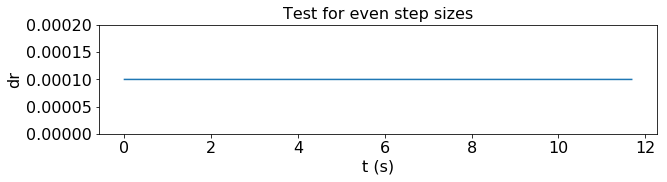

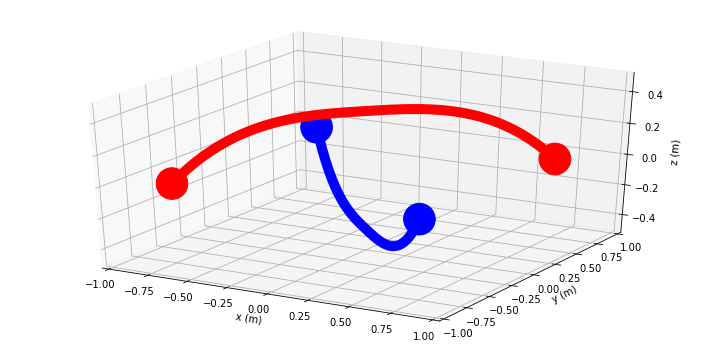

In [4]:
s_test = {
    'DT': .0005, 'SPD': .2,
    'TRJ': [
        {'START': (-0.75, -0.75), 'END': (0.75, 0.75), 'H': .38, 'K': 3},
        {'START': (0.75, -0.75), 'END': (-0.75, 0.75), 'H': -.38, 'K': 3},
    ]
}

cs = ['r', 'b']

trjs = build_trjs(s_test)

# test step length
dx = np.diff(trjs[0]['x'])
dy = np.diff(trjs[0]['y'])
dz = np.diff(trjs[0]['z'])

d = np.sqrt(dx**2 + dy**2 + dz**2)

fig, ax = plt.subplots(1, 1, figsize=(10, 2))
ax.plot(trjs[0]['t'][1:], d)
ax.set_ylim(0, 2*s_test['DT']*s_test['SPD'])
ax.set_xlabel('t (s)')
ax.set_ylabel('dr')
ax.set_title('Test for even step sizes')

set_font_size(ax, 16)

fig = plt.figure(figsize=(10, 5), tight_layout=True)
ax = fig.add_subplot(111, projection='3d')

for trj, p_trj, c in zip(trjs, s_test['TRJ'], cs):
    ax.plot(trj['x'], trj['y'], trj['z'], c=c, lw=10)
    ax.scatter(
        [p_trj['START'][0], p_trj['END'][0]],
        [p_trj['START'][1], p_trj['END'][1]],
        [0, 0], c=c, s=1000, alpha=1)

ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
ax.set_zlim(-.5, .5)

ax.set_xlabel('x (m)')
ax.set_ylabel('y (m)')
ax.set_zlabel('z (m)')

Write funcs to build trajectory "veil".

In [5]:
def dist_to_trj(pfxs, pfys, pfzs, x, y, z):
    """
    Compute distance of static points (pfxs, pfys) to trajectory (x(t), y(t)).
    
    :return: dists to nearest pts, idxs of nearest pts
    """
    # get dists to all pts along trj
    dx = np.tile(pfxs[None, :], (len(x), 1)) - np.tile(x[:, None], (1, len(pfxs)))
    dy = np.tile(pfys[None, :], (len(y), 1)) - np.tile(y[:, None], (1, len(pfys)))
    dz = np.tile(pfzs[None, :], (len(z), 1)) - np.tile(z[:, None], (1, len(pfzs)))
    
    d = np.sqrt(dx**2 + dy**2 + dz**2)
    
    # return dists of cells to nearest pts on trj
    return np.min(d, 0), np.argmin(d, 0)


def get_trj_veil(trjs, ntwk, m, s):
    """
    Return a "veil" (positive real-valued mask) over cells in the ntwk
    with place fields along the trajectory path.
    """
    veils = []
    
    for trj in trjs:
        
        # compute scale factor for all PCs
        ## get distance to trj
        d = dist_to_trj(ntwk.pfxs, ntwk.pfys, ntwk.pfzs, trj['x'], trj['y'], trj['z'])[0]

        # sensory-driven firing rates as function of d
        r = m['R_MAX'] * np.exp(-.5*(d**2)/(m['L_PL']**2))
        sgm = 1 + (m['SGM_MAX'] - 1) * sgmd(m['B_SGM']*(r - m['R_SGM']))
        veils.append(sgm - 1)
        
    veil = np.max(np.array(veils), 0)
    
    return veil

## Test LTP-IE profile generation in 3D

In [6]:
ntwk = build_ntwk(M, S)
trjs = build_trjs(S)

# get trj veil
trj_veil = get_trj_veil(trjs, ntwk, M, S)

ntwk.sgm = trj_veil + 1

# approximate G->PC weights if desired
ntwk = smln.apx_ws_up(ntwk, trj_veil)

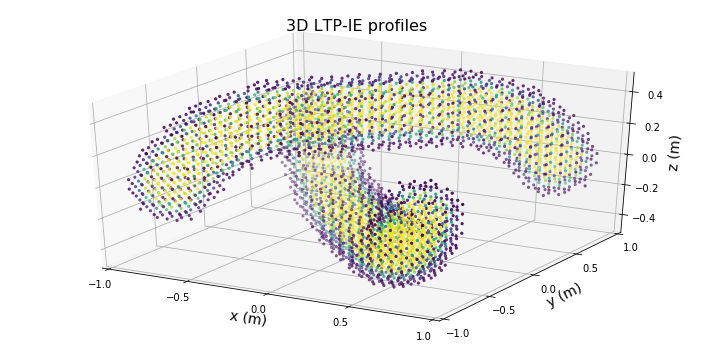

In [7]:
fig = plt.figure(figsize=(10, 5), tight_layout=True)
ax = fig.add_subplot(111, projection='3d')

ax.scatter(
    ntwk.pfxs[ntwk.sgm > 1.01], ntwk.pfys[ntwk.sgm > 1.01], ntwk.pfzs[ntwk.sgm > 1.01],
    s=5, c=ntwk.sgm[ntwk.sgm > 1.01], cmap='viridis')

ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
ax.set_zlim(-.5, .5)

set_n_x_ticks(ax, 5)
set_n_y_ticks(ax, 5)

ax.set_xlabel('x (m)', fontsize=14)
ax.set_ylabel('y (m)', fontsize=14)
ax.set_zlabel('z (m)', fontsize=14)

ax.set_title('3D LTP-IE profiles', fontsize=16)